In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import BaggingClassifier
#from imblearn.combine import SMOTEENN
import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
#import toad
import pickle

In [2]:
train_data=pd.read_csv("training_set.csv")
test_data=pd.read_csv("test_set.csv")

In [3]:
x_train=train_data.iloc[:,0:22]
y_train=train_data.iloc[:,22:23]
x_test=test_data.iloc[:,0:22]
y_test=test_data.iloc[:,22:23]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(22500, 22) (22500, 1) (7500, 22) (7500, 1)


In [4]:
y_train=np.array(y_train)
y_train=y_train.ravel()
y_test=np.array(y_test)
y_test=y_test.ravel()

In [5]:
under_sampler = RandomUnderSampler(sampling_strategy=0.6)
x_resampled, y_resampled = under_sampler.fit_resample(x_train, y_train)

# Apply over-sampling using SMOTE
over_sampler = SMOTE(sampling_strategy=0.8)
x_resampled, y_resampled = over_sampler.fit_resample(x_resampled, y_resampled)

### Bagged Decision Tree

In [6]:
## training result without tuning and sampling
model_DT = BaggingClassifier()
model_DT.fit(x_train,y_train)
pred_DT = model_DT.predict(x_test)
print("DT Train set Accuracy: ", metrics.accuracy_score(y_train, model_DT.predict(x_train)))
print("DT Test set Accuracy: ", metrics.accuracy_score(y_test, pred_DT))
print(classification_report(y_test, pred_DT))

DT Train set Accuracy:  0.9796
DT Test set Accuracy:  0.7566666666666667
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      5952
           1       0.38      0.29      0.33      1548

    accuracy                           0.76      7500
   macro avg       0.60      0.58      0.59      7500
weighted avg       0.73      0.76      0.74      7500



In [7]:
## resampled data results with no tuning
model_DT = BaggingClassifier()
model_DT.fit(x_resampled,y_resampled)
pred_DT = model_DT.predict(x_test)
print("DT Train set Accuracy: ", metrics.accuracy_score(y_resampled, model_DT.predict(x_resampled)))
print("DT Test set Accuracy: ", metrics.accuracy_score(y_test, pred_DT))
print(classification_report(y_test, pred_DT))

DT Train set Accuracy:  0.9795597484276729
DT Test set Accuracy:  0.7145333333333334
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      5952
           1       0.36      0.49      0.42      1548

    accuracy                           0.71      7500
   macro avg       0.61      0.63      0.61      7500
weighted avg       0.75      0.71      0.73      7500



Area under the curve: 0.6667989697077047


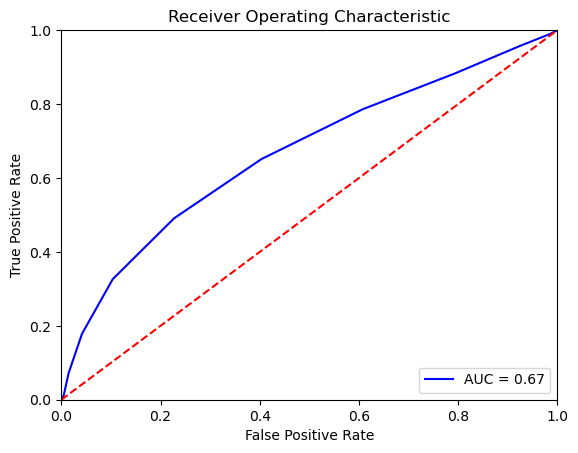

In [8]:
preds_DT = model_DT.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_DT)  
roc_auc_DT = metrics.auc(fpr, tpr)
print("Area under the curve:",roc_auc_DT)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_DT)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Tuned Result

In [9]:
## Training data tuned
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/daoduyhung/miniconda3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.805185 using {'n_estimators': 1000}
0.792800 (0.006286) with: {'n_estimators': 10}
0.803378 (0.006426) with: {'n_estimators': 100}
0.805185 (0.006410) with: {'n_estimators': 1000}


In [10]:
## tuned training results
## training result without tuning and sampling
model_DT = BaggingClassifier(n_estimators = 1000)
model_DT.fit(x_train,y_train)
pred_DT = model_DT.predict(x_test)
print("DT Train set Accuracy: ", metrics.accuracy_score(y_train, model_DT.predict(x_train)))
print("DT Test set Accuracy: ", metrics.accuracy_score(y_test, pred_DT))
print(classification_report(y_test, pred_DT))

DT Train set Accuracy:  1.0
DT Test set Accuracy:  0.7808
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      5952
           1       0.46      0.39      0.42      1548

    accuracy                           0.78      7500
   macro avg       0.66      0.64      0.64      7500
weighted avg       0.77      0.78      0.77      7500



In [11]:
## Resampled data tuned
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_resampled, y_resampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759150 using {'n_estimators': 1000}
0.741265 (0.010681) with: {'n_estimators': 10}
0.757512 (0.009449) with: {'n_estimators': 100}
0.759150 (0.010040) with: {'n_estimators': 1000}


In [12]:
model_DT = BaggingClassifier(n_estimators = 1000)
model_DT.fit(x_resampled,y_resampled)
pred_DT = model_DT.predict(x_test)
print("DT Train set Accuracy: ", metrics.accuracy_score(y_resampled, model_DT.predict(x_resampled)))
print("DT Test set Accuracy: ", metrics.accuracy_score(y_test, pred_DT))
print(classification_report(y_test, pred_DT))

DT Train set Accuracy:  1.0
DT Test set Accuracy:  0.7665333333333333
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5952
           1       0.44      0.52      0.48      1548

    accuracy                           0.77      7500
   macro avg       0.66      0.68      0.66      7500
weighted avg       0.78      0.77      0.77      7500

